## Cryptocurrency price prediction using Probabilistic neural network

In [1]:
# Edit all the Mardown cells below with the appropriate information 
# Run all cells, containing your code 
# Save this Jupyter with the outputs of your executed cells
#
# PS: Save again the notebook with this outcome.
# PSPS: Don't forget to include the dataset in your submission


**Course:** DAAN 897– Deep Learning (Spring II, 2020)

### Problem Statement
* This project implements a hybrid LSTM-PNN model and compares it with traditional LSTM model to predict cryptocurrency prices.We have also implemented a Neural Prophet network to study its prediction capability.
The cryptocurrency used for this project are : Bitcoin, Ethereum, Cardano.
    
    
    

	

### Data Collection
* Source(url):https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory
* Short Description : The Kaggle dataset “Cryptocurrency price history” was utilized for this project.​

The dataset has one csv file for each currency. Price history is available daily from April 28, 2013. This dataset has the historical price information of some of the top crypto currencies by market capitalization. ​

In this dataset, there are 23 files in total, and each file documents the information such date, price values, volume and market capitalization for each cryptocurrency. We chose to use the Top 3 popular cryptocurrency historical prices, and they are Bitcoin (BTC), Ethereum (ETH), and Cardano (ADA).​



### Required packages

* tensorflow probability


In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
import tensorflow.keras.backend as k
from neuralprophet import NeuralProphet
import tensorflow_probability as tfp

from tensorflow.keras.models import Sequential
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
df = pd.read_csv("./coin_Bitcoin.csv", parse_dates=['Date'])
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


Text(0, 0.5, 'Close Price (USD)')

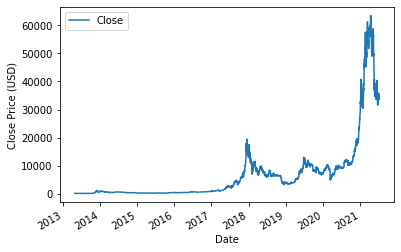

In [4]:
df.shape
df = df.sort_values('Date')
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [5]:
df.describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2.991000e+03,2.991000e+03
mean,1496.000000,6893.326038,6486.009539,6700.146240,6711.290443,1.090633e+10,1.208761e+11
std,863.571653,11642.832456,10869.032130,11288.043736,11298.141921,1.888895e+10,2.109438e+11
min,1.000000,74.561096,65.526001,68.504997,68.431000,0.000000e+00,7.784112e+08
25%,748.500000,436.179001,422.879486,430.445496,430.569489,3.036725e+07,6.305579e+09
50%,1496.000000,2387.610107,2178.500000,2269.889893,2286.409912,9.460360e+08,3.741503e+10
75%,2243.500000,8733.926948,8289.800459,8569.656494,8576.238715,1.592015e+10,1.499957e+11
max,2991.000000,64863.098908,62208.964366,63523.754869,63503.457930,3.509679e+11,1.186364e+12


# Data Preprocessing

* 1. Normalisation

In [6]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(2991, 1)

2. Remove NaN values if any

In [7]:
np.isnan(scaled_close).any()


False

In [8]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)
np.isnan(scaled_close).any()

False

In [9]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.90)

In [10]:
X_test.shape

(290, 99, 1)

# Methodology

1. We have 3 models in total to predict cryptocurrency prices.
     1.A baseline LSTM model.
     2.A hybrid model that combines LSTM and PNN.
     3.Finally,  Neural Prophet model.


2. Introduce the Deep Neural Networks you used in your project
 * Baseline model
    * A 3-layer LSTM Recurrent Neural Network was created on the normalized data. The network was made bidirectional in order to train on the sequence data in forward and backward (reversed) direction.The output layer has a single neuron and ‘Linear’ activation function was used.
 
 * Hybrid model LSTM PNN
    * The output from the last LSTM layer of the baseline model goes to 2 different layers:
    1.A keras dense layer with 16 neurons
    2.A tensorflow probability layer that fits the inputs to a normal distribution
    3.These two layers are then merged into a single dense layer.
    4.The output layer has a single neuron and ‘Linear’ activation function was used.
    5.A custom loss function was used to assess the model.
  
 * Neural Prophet Model
     * Description 
 

# Baseline LSTM Model for 3 different cryptocurrencies

In [11]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),  input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

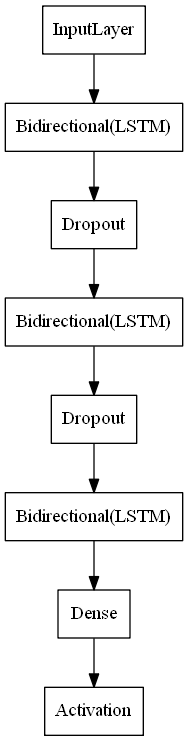

In [12]:
model.compile(
    loss = 'MSE',
    optimizer='adam'
)

plot_model(model, to_file='model_plot.png', show_shapes=False, show_dtype=False, show_layer_names=False)

## Model Fitting and Validation

1. Baseline 
    - decription 
2. Hybrid Model
    - decription 

In [13]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1,   
)

Epoch 1/50
37/37 [==============================] - 13s 109ms/step - loss: 0.0020 - val_loss: 3.9849e-04
Epoch 2/50
37/37 [==============================] - 2s 59ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 3/50
37/37 [==============================] - 2s 62ms/step - loss: 4.0314e-04 - val_loss: 3.5813e-04
Epoch 4/50
37/37 [==============================] - 2s 59ms/step - loss: 9.1950e-05 - val_loss: 1.0585e-04
Epoch 5/50
37/37 [==============================] - 2s 61ms/step - loss: 1.6397e-04 - val_loss: 9.8089e-05
Epoch 6/50
37/37 [==============================] - 2s 58ms/step - loss: 1.6127e-04 - val_loss: 1.4848e-04
Epoch 7/50
37/37 [==============================] - 2s 58ms/step - loss: 3.1414e-04 - val_loss: 9.0675e-05
Epoch 8/50
37/37 [==============================] - 2s 58ms/step - loss: 2.1234e-04 - val_loss: 2.6928e-04
Epoch 9/50
37/37 [==============================] - 2s 58ms/step - loss: 5.2871e-04 - val_loss: 3.3355e-04
Epoch 10/50
37/37 [============================

### Model Evaluation 

* Examine your models (coefficients, parameters, errors, etc...)

* Compute and interpret your results in terms of accuracy, precision, recall, ROC etc. 

In [14]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 19ms/step - loss: 0.0420


0.04202243685722351

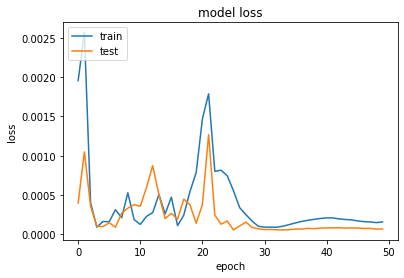

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

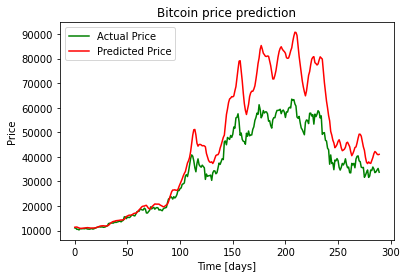

In [16]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

### Ethereum

In [17]:
df = pd.read_csv("./coin_Ethereum.csv", parse_dates=['Date'])
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Ethereum,ETH,2015-08-08 23:59:59,2.798810,0.714725,2.793760,0.753325,674188.0,4.548689e+07
1,2,Ethereum,ETH,2015-08-09 23:59:59,0.879810,0.629191,0.706136,0.701897,532170.0,4.239957e+07
2,3,Ethereum,ETH,2015-08-10 23:59:59,0.729854,0.636546,0.713989,0.708448,405283.0,4.281836e+07
3,4,Ethereum,ETH,2015-08-11 23:59:59,1.131410,0.663235,0.708087,1.067860,1463100.0,6.456929e+07
4,5,Ethereum,ETH,2015-08-12 23:59:59,1.289940,0.883608,1.058750,1.217440,2150620.0,7.364501e+07


Text(0, 0.5, 'Close Price (USD)')

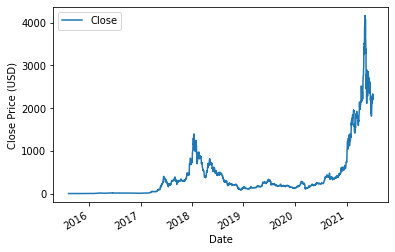

In [18]:
df.shape
df = df.sort_values('Date')
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [19]:
df.describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2.160000e+03,2.160000e+03
mean,1080.500000,398.258568,365.592589,382.879899,383.910691,7.057058e+09,4.172084e+10
std,623.682612,628.082281,566.611523,599.719862,601.078766,1.064526e+10,6.909184e+10
min,1.000000,0.482988,0.420897,0.431589,0.434829,1.021280e+05,3.221363e+07
25%,540.750000,14.265225,13.190950,13.757600,13.819200,3.825102e+07,1.135576e+09
50%,1080.500000,205.124631,193.302715,198.425096,198.643691,2.148880e+09,2.070063e+10
75%,1620.250000,396.494561,375.146804,386.264935,386.435272,9.629136e+09,4.231010e+10
max,2160.000000,4362.350542,3785.848603,4174.635873,4168.701049,8.448291e+10,4.828819e+11


In [20]:
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [21]:
scaled_close.shape

(2160, 1)

In [22]:
np.isnan(scaled_close).any()

False

In [23]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [24]:
scaled_close = scaled_close.reshape(-1, 1)

In [25]:
np.isnan(scaled_close).any()

False

In [26]:
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.90)
X_test.shape

(206, 99, 1)

In [27]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),  input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [28]:
model.compile(
    loss = 'MSE',
    optimizer='adam'
)

In [29]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1,
    
)

Epoch 1/50
27/27 [==============================] - 12s 125ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 2/50
27/27 [==============================] - 2s 56ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 3/50
27/27 [==============================] - 1s 55ms/step - loss: 0.0029 - val_loss: 7.0702e-04
Epoch 4/50
27/27 [==============================] - 1s 54ms/step - loss: 4.0415e-04 - val_loss: 7.1006e-04
Epoch 5/50
27/27 [==============================] - 1s 55ms/step - loss: 7.3748e-04 - val_loss: 2.0596e-04
Epoch 6/50
27/27 [==============================] - 1s 54ms/step - loss: 0.0015 - val_loss: 2.8100e-04
Epoch 7/50
27/27 [==============================] - 1s 54ms/step - loss: 2.2919e-04 - val_loss: 2.1325e-04
Epoch 8/50
27/27 [==============================] - 1s 54ms/step - loss: 1.6322e-04 - val_loss: 6.5127e-05
Epoch 9/50
27/27 [==============================] - 1s 54ms/step - loss: 1.3623e-04 - val_loss: 1.2940e-04
Epoch 10/50
27/27 [==============================] - 1s 55m

In [30]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 17ms/step - loss: 0.0585


0.05845358222723007

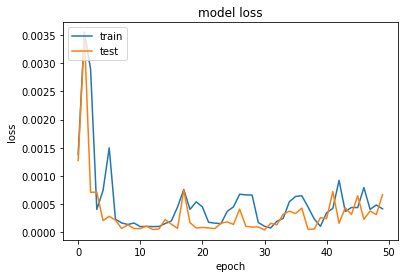

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

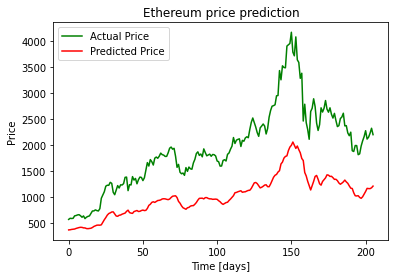

In [32]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ethereum price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

### Cardano

In [33]:
df = pd.read_csv("./coin_Cardano.csv", parse_dates=['Date'])
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Cardano,ADA,2017-10-02 23:59:59,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
1,2,Cardano,ADA,2017-10-03 23:59:59,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2,3,Cardano,ADA,2017-10-04 23:59:59,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
3,4,Cardano,ADA,2017-10-05 23:59:59,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
4,5,Cardano,ADA,2017-10-06 23:59:59,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


Text(0, 0.5, 'Close Price (USD)')

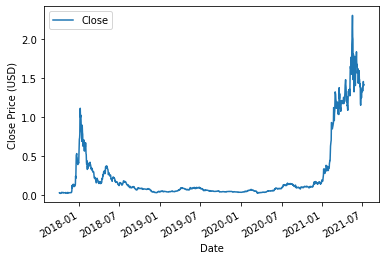

In [34]:
df.shape
df = df.sort_values('Date')
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [35]:
df.describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1.374000e+03,1.374000e+03
mean,687.500000,0.269807,0.239710,0.255287,0.256313,8.934183e+08,7.603454e+09
std,396.783946,0.433523,0.380928,0.408456,0.409691,2.107653e+09,1.303878e+10
min,1.000000,0.021050,0.017620,0.018414,0.018539,1.739460e+06,4.806646e+08
25%,344.250000,0.047565,0.044601,0.045898,0.045947,5.014830e+07,1.191263e+09
50%,687.500000,0.090274,0.083164,0.086867,0.087002,1.186742e+08,2.270889e+09
75%,1030.750000,0.194519,0.172442,0.181374,0.183379,4.875977e+08,5.174547e+09
max,1374.000000,2.461766,2.013285,2.300190,2.309113,1.914198e+10,7.377224e+10


In [36]:
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1374, 1)

In [37]:
np.isnan(scaled_close).any()
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)
np.isnan(scaled_close).any()

False

In [38]:
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.90)
X_test.shape

(128, 99, 1)

In [39]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),  input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [40]:
model.compile(
    loss = 'MSE',
    optimizer='adam'
)

In [41]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1,
    
)

Epoch 1/50
17/17 [==============================] - 12s 167ms/step - loss: 0.0034 - val_loss: 0.0179
Epoch 2/50
17/17 [==============================] - 1s 59ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 3/50
17/17 [==============================] - 1s 56ms/step - loss: 3.0280e-04 - val_loss: 0.0164
Epoch 4/50
17/17 [==============================] - 1s 54ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 5/50
17/17 [==============================] - 1s 55ms/step - loss: 5.0013e-04 - val_loss: 0.0142
Epoch 6/50
17/17 [==============================] - 1s 54ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 7/50
17/17 [==============================] - 1s 55ms/step - loss: 4.9690e-04 - val_loss: 0.0160
Epoch 8/50
17/17 [==============================] - 1s 55ms/step - loss: 0.0012 - val_loss: 0.0083
Epoch 9/50
17/17 [==============================] - 1s 55ms/step - loss: 3.1944e-04 - val_loss: 8.8218e-04
Epoch 10/50
17/17 [==============================] - 1s 54ms/step - loss: 7.3542e-04 - 

In [42]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 26ms/step - loss: 0.0073


0.007340879645198584

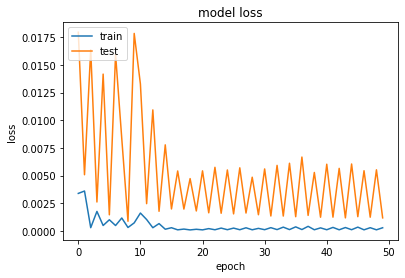

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

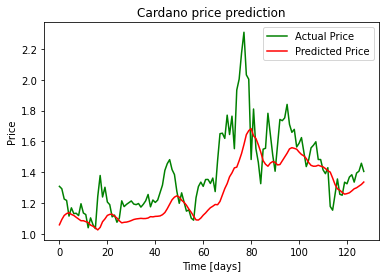

In [44]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Cardano price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

# Hybrid Model with LSTM-PNN

# Bitcoin

In [45]:
df = pd.read_csv("./coin_Bitcoin.csv", parse_dates=['Date'])

### Preprocessing

In [46]:
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [47]:
np.isnan(scaled_close).any()

False

In [48]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [49]:
scaled_close = scaled_close.reshape(-1, 1)

In [50]:
np.isnan(scaled_close).any()

False

In [51]:
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.90)

### Model

In [52]:
tfd = tfp.distributions

def my_dist(params): #B
  return tfd.Normal(loc=params, scale=1)

In [53]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

visible = keras.layers.Input(shape = (WINDOW_SIZE, X_train.shape[-1]))

lstm1 = Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),  input_shape=(WINDOW_SIZE, X_train.shape[-1]))(visible)
dropout1 = Dropout(rate=DROPOUT)(lstm1)
lstm2 = Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True))(dropout1)
dropout2 = Dropout(rate=DROPOUT)(lstm2)
lstm3 = Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False))(dropout2)

prob1 = tfp.layers.DistributionLambda(my_dist)(lstm3)
dense1 = Dense(units=16)(lstm3)

merge = concatenate([dense1, prob1])
dense2 = Dense(units=16)(merge)
output = Dense(units=1, activation='linear')(merge)

model = keras.models.Model(inputs=visible, outputs=output)

# Train

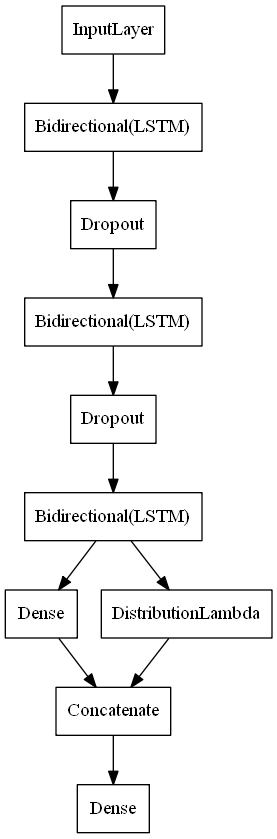

In [54]:
def f(y, mu, sigma=20):
  return (1/(sigma * tf.math.sqrt(2 * np.pi)) * tf.math.exp( - (y - mu)**2 / (2 * sigma**2)))

def my_loss(y_true,y_pred): #A
  loss = -tf.reduce_sum(tf.math.log(f(y_true,y_pred)))
  return loss

model.compile(
    loss = my_loss,
    optimizer='adam',
    metrics = ['MSE']
)

plot_model(model, to_file='model_plot_PNN.png', show_shapes=False, show_dtype=False, show_layer_names=False)

In [55]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1,
    
)

Epoch 1/50
37/37 [==============================] - 13s 130ms/step - loss: 248.9600 - MSE: 1.3487 - val_loss: 246.1996 - val_MSE: 1.0930
Epoch 2/50
37/37 [==============================] - 2s 56ms/step - loss: 248.9256 - MSE: 0.9164 - val_loss: 246.1592 - val_MSE: 0.5691
Epoch 3/50
37/37 [==============================] - 2s 56ms/step - loss: 248.8983 - MSE: 0.5743 - val_loss: 246.1493 - val_MSE: 0.4405
Epoch 4/50
37/37 [==============================] - 2s 56ms/step - loss: 248.8790 - MSE: 0.3323 - val_loss: 246.1318 - val_MSE: 0.2212
Epoch 5/50
37/37 [==============================] - 2s 58ms/step - loss: 248.8687 - MSE: 0.2020 - val_loss: 246.1237 - val_MSE: 0.1179
Epoch 6/50
37/37 [==============================] - 2s 58ms/step - loss: 248.8615 - MSE: 0.1126 - val_loss: 246.1210 - val_MSE: 0.0860
Epoch 7/50
37/37 [==============================] - 2s 57ms/step - loss: 248.8569 - MSE: 0.0537 - val_loss: 246.1173 - val_MSE: 0.0390
Epoch 8/50
37/37 [==============================] - 2

# Evaluate

In [56]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 24ms/step - loss: 124.4602 - MSE: 0.0163


[124.4601821899414, 0.016347836703062057]

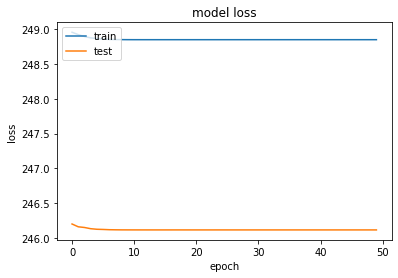

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

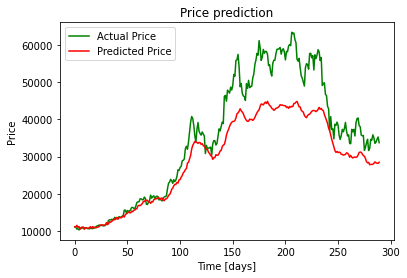

In [58]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

# Ethereum

In [59]:
df = pd.read_csv("./coin_Ethereum.csv", parse_dates=['Date'])

In [60]:
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [61]:
np.isnan(scaled_close).any()

False

In [62]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [63]:
scaled_close = scaled_close.reshape(-1, 1)

In [64]:
np.isnan(scaled_close).any()

False

In [65]:
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.90)
X_test.shape

(206, 99, 1)

In [66]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

visible = keras.layers.Input(shape = (WINDOW_SIZE, X_train.shape[-1]))

lstm1 = Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),  input_shape=(WINDOW_SIZE, X_train.shape[-1]))(visible)
dropout1 = Dropout(rate=DROPOUT)(lstm1)
lstm2 = Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True))(dropout1)
dropout2 = Dropout(rate=DROPOUT)(lstm2)
lstm3 = Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False))(dropout2)

prob1 = tfp.layers.DistributionLambda(my_dist)(lstm3)
dense1 = Dense(units=16)(lstm3)

merge = concatenate([dense1, prob1])
dense2 = Dense(units=16)(merge)
output = Dense(units=1, activation='linear')(merge)

model = keras.models.Model(inputs=visible, outputs=output)

In [67]:
model.compile(
    loss = my_loss,
    optimizer='adam',
    metrics = ['MSE']
)

In [68]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1,
)

Epoch 1/50
27/27 [==============================] - 12s 129ms/step - loss: 250.1217 - MSE: 1.8269 - val_loss: 243.3180 - val_MSE: 1.3234
Epoch 2/50
27/27 [==============================] - 2s 57ms/step - loss: 250.0898 - MSE: 1.4293 - val_loss: 243.3091 - val_MSE: 1.2155
Epoch 3/50
27/27 [==============================] - 2s 56ms/step - loss: 250.0579 - MSE: 1.0315 - val_loss: 243.2833 - val_MSE: 0.8792
Epoch 4/50
27/27 [==============================] - 2s 61ms/step - loss: 250.0397 - MSE: 0.8017 - val_loss: 243.2808 - val_MSE: 0.8425
Epoch 5/50
27/27 [==============================] - 2s 61ms/step - loss: 250.0231 - MSE: 0.5954 - val_loss: 243.2550 - val_MSE: 0.5220
Epoch 6/50
27/27 [==============================] - 2s 59ms/step - loss: 250.0098 - MSE: 0.4269 - val_loss: 243.2409 - val_MSE: 0.3400
Epoch 7/50
27/27 [==============================] - 2s 59ms/step - loss: 249.9992 - MSE: 0.2939 - val_loss: 243.2318 - val_MSE: 0.2215
Epoch 8/50
27/27 [==============================] - 2

In [69]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 20ms/step - loss: 120.4823 - MSE: 0.0428


[120.48230743408203, 0.04276713728904724]

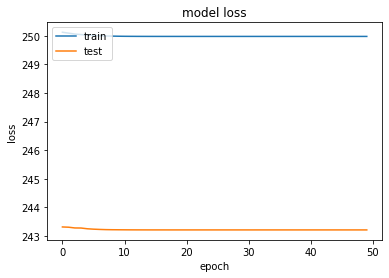

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

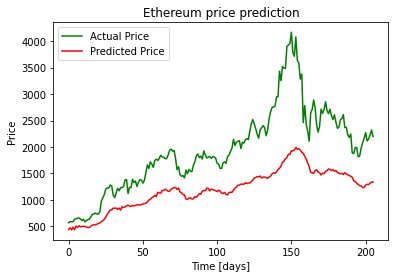

In [71]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ethereum price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

# Cardano

In [72]:
df = pd.read_csv("./coin_Cardano.csv", parse_dates=['Date'])

In [73]:
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1374, 1)

In [74]:
np.isnan(scaled_close).any()
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)
np.isnan(scaled_close).any()

False

In [75]:
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.90)
X_test.shape

(128, 99, 1)

In [76]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

visible = keras.layers.Input(shape = (WINDOW_SIZE, X_train.shape[-1]))

lstm1 = Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),  input_shape=(WINDOW_SIZE, X_train.shape[-1]))(visible)
dropout1 = Dropout(rate=DROPOUT)(lstm1)
lstm2 = Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True))(dropout1)
dropout2 = Dropout(rate=DROPOUT)(lstm2)
lstm3 = Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False))(dropout2)

prob1 = tfp.layers.DistributionLambda(my_dist)(lstm3)
dense1 = Dense(units=16)(lstm3)

merge = concatenate([dense1, prob1])
dense2 = Dense(units=16)(merge)
output = Dense(units=1, activation='linear')(merge)

model = keras.models.Model(inputs=visible, outputs=output)

In [77]:
model.compile(
    loss = my_loss,
    optimizer='adam',
    metrics = ['MSE']
)

In [78]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1,
)

Epoch 1/50
17/17 [==============================] - 11s 168ms/step - loss: 249.1588 - MSE: 1.6949 - val_loss: 228.1105 - val_MSE: 1.9257
Epoch 2/50
17/17 [==============================] - 1s 58ms/step - loss: 249.1436 - MSE: 1.5067 - val_loss: 228.0885 - val_MSE: 1.6144
Epoch 3/50
17/17 [==============================] - 1s 56ms/step - loss: 249.1209 - MSE: 1.2277 - val_loss: 228.0589 - val_MSE: 1.2163
Epoch 4/50
17/17 [==============================] - 1s 57ms/step - loss: 249.1098 - MSE: 1.0759 - val_loss: 228.0605 - val_MSE: 1.2361
Epoch 5/50
17/17 [==============================] - 1s 57ms/step - loss: 249.0945 - MSE: 0.8842 - val_loss: 228.0294 - val_MSE: 0.8130
Epoch 6/50
17/17 [==============================] - 1s 56ms/step - loss: 249.0804 - MSE: 0.7113 - val_loss: 228.0174 - val_MSE: 0.6571
Epoch 7/50
17/17 [==============================] - 1s 57ms/step - loss: 249.0754 - MSE: 0.6451 - val_loss: 228.0072 - val_MSE: 0.5142
Epoch 8/50
17/17 [==============================] - 1

In [79]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 26ms/step - loss: 125.2707 - MSE: 0.0319


[125.27073669433594, 0.031875431537628174]

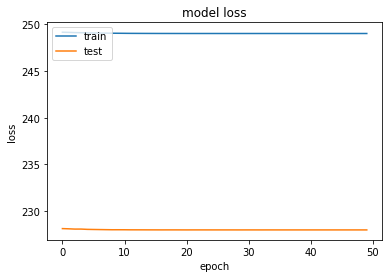

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

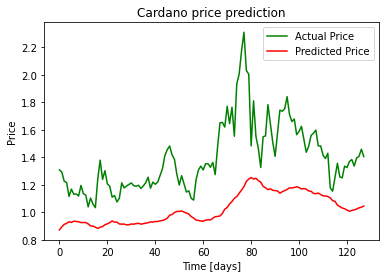

In [81]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Cardano price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

# Neural Prophet Model

In [87]:
df = pd.read_csv("./coin_Bitcoin.csv", parse_dates=['Date'])
df.sort_values('Date')

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


In [88]:
input_data = df.rename(columns={'Date': 'ds', 'Close': 'y'})[['ds', 'y']]

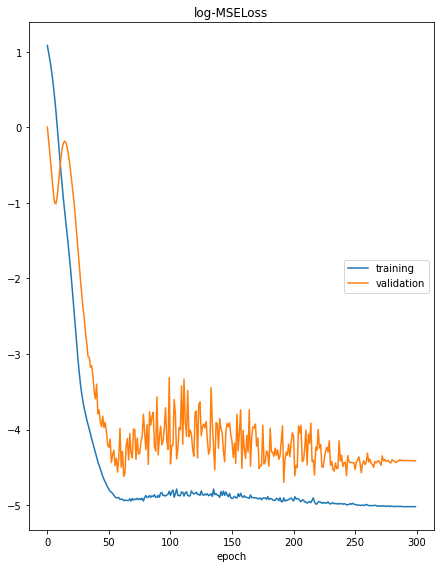

Epoch[300/300]: 100%|█| 300/300 [00:40<00:00,  7.39it/s, MSELoss=0.00661, MAE=1.75e+3, RMSE=2.83e+3, RegLoss=0, MAE_val


In [89]:
m = NeuralProphet(seasonality_mode='multiplicative', loss_func='MSE')

df_train, df_test = m.split_df(df=input_data, freq="D", valid_p=0.1)

metrics = m.fit(input_data, freq='D', validation_df=df_test,
                    plot_live_loss=True, epochs=300)

In [90]:
def plot_forecast(model, data, periods, historic_pred=True, highlight_steps_ahead=None):
  
    """ plot_forecast function - generates and plots the forecasts for a NeuralProphet model
    - model -> a trained NeuralProphet model
    - data -> the dataframe used for training
    - periods -> the number of periods to forecast
    - historic_pred -> a flag indicating whether or not to plot the model's predictions on historic data
    - highlight_steps_ahead -> the number of steps ahead of the forecast line to highlight, used for autoregressive models only"""
    
    future = model.make_future_dataframe(data, 
                                         periods=periods, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    if highlight_steps_ahead is not None:
        model = model.highlight_nth_step_ahead_of_each_forecast(highlight_steps_ahead)
        model.plot_last_forecast(forecast)
    else:    
        model.plot(forecast)

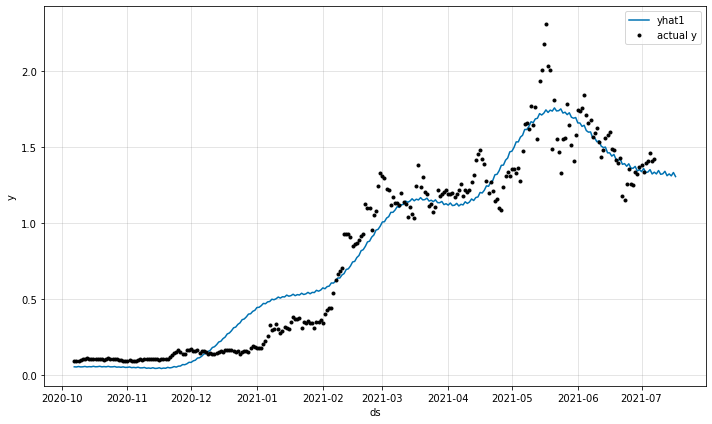

In [100]:
plot_forecast(m, df_test, periods=10)

In [101]:
df = pd.read_csv("./coin_Ethereum.csv", parse_dates=['Date'])
df.sort_values('Date')

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Ethereum,ETH,2015-08-08 23:59:59,2.798810,0.714725,2.793760,0.753325,6.741880e+05,4.548689e+07
1,2,Ethereum,ETH,2015-08-09 23:59:59,0.879810,0.629191,0.706136,0.701897,5.321700e+05,4.239957e+07
2,3,Ethereum,ETH,2015-08-10 23:59:59,0.729854,0.636546,0.713989,0.708448,4.052830e+05,4.281836e+07
3,4,Ethereum,ETH,2015-08-11 23:59:59,1.131410,0.663235,0.708087,1.067860,1.463100e+06,6.456929e+07
4,5,Ethereum,ETH,2015-08-12 23:59:59,1.289940,0.883608,1.058750,1.217440,2.150620e+06,7.364501e+07
...,...,...,...,...,...,...,...,...,...,...
2155,2156,Ethereum,ETH,2021-07-02 23:59:59,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11
2156,2157,Ethereum,ETH,2021-07-03 23:59:59,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11
2157,2158,Ethereum,ETH,2021-07-04 23:59:59,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11
2158,2159,Ethereum,ETH,2021-07-05 23:59:59,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11


In [102]:
input_data = df.rename(columns={'Date': 'ds', 'Close': 'y'})[['ds', 'y']]

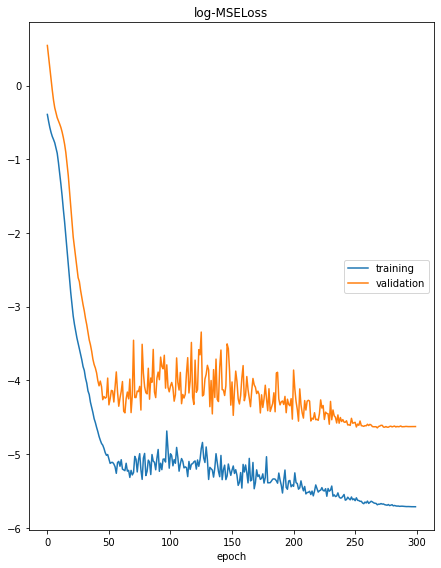

Epoch[300/300]: 100%|█| 300/300 [00:31<00:00,  9.44it/s, MSELoss=0.0033, MAE=60.3, RMSE=99.4, RegLoss=0, MAE_val=117, M


In [103]:
m = NeuralProphet(seasonality_mode='multiplicative', loss_func='MSE')

df_train, df_test = m.split_df(df=input_data, freq="D", valid_p=0.2)

metrics = m.fit(input_data, freq='D', validation_df=df_test,
                    plot_live_loss=True, epochs=300)

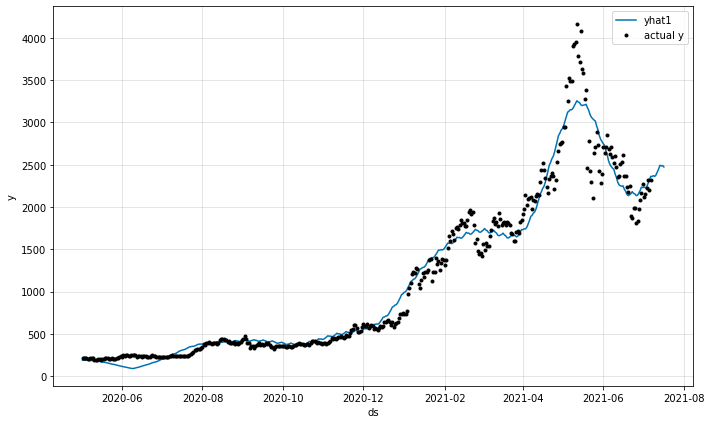

In [104]:
plot_forecast(m, df_test, periods=10)

In [105]:
df = pd.read_csv("./coin_Cardano.csv", parse_dates=['Date'])
df.sort_values('Date')

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Cardano,ADA,2017-10-02 23:59:59,0.030088,0.019969,0.024607,0.025932,5.764130e+07,6.288991e+08
1,2,Cardano,ADA,2017-10-03 23:59:59,0.027425,0.020690,0.025757,0.020816,1.699780e+07,5.396927e+08
2,3,Cardano,ADA,2017-10-04 23:59:59,0.022806,0.020864,0.020864,0.021931,9.000050e+06,5.686195e+08
3,4,Cardano,ADA,2017-10-05 23:59:59,0.022154,0.020859,0.021951,0.021489,5.562510e+06,5.571390e+08
4,5,Cardano,ADA,2017-10-06 23:59:59,0.021542,0.018360,0.021359,0.018539,7.780710e+06,4.806646e+08
...,...,...,...,...,...,...,...,...,...,...
1369,1370,Cardano,ADA,2021-07-02 23:59:59,1.394397,1.286607,1.332942,1.394397,2.159410e+09,4.454587e+10
1370,1371,Cardano,ADA,2021-07-03 23:59:59,1.441714,1.359664,1.394152,1.406836,2.028094e+09,4.494324e+10
1371,1372,Cardano,ADA,2021-07-04 23:59:59,1.493717,1.382153,1.404008,1.458184,1.806362e+09,4.658364e+10
1372,1373,Cardano,ADA,2021-07-05 23:59:59,1.461221,1.379284,1.461221,1.404898,1.759461e+09,4.488134e+10


In [106]:
input_data = df.rename(columns={'Date': 'ds', 'Close': 'y'})[['ds', 'y']]

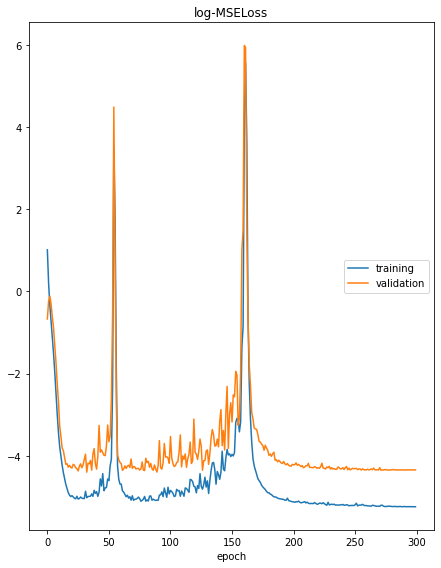

Epoch[300/300]: 100%|█| 300/300 [00:21<00:00, 14.18it/s, MSELoss=0.00531, MAE=0.0561, RMSE=0.0909, RegLoss=0, MAE_val=0


In [107]:
m = NeuralProphet(seasonality_mode='multiplicative', loss_func='MSE')

df_train, df_test = m.split_df(df=input_data, freq="D", valid_p=0.2)

metrics = m.fit(input_data, freq='D', validation_df=df_test,
                    plot_live_loss=True, epochs=300)

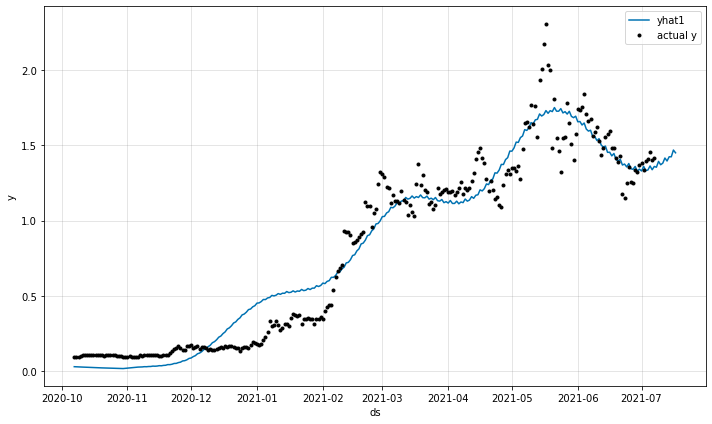

In [108]:
plot_forecast(m, df_test, periods=10)

### Issues / Improvements
1. Dataset is very small
2. Experiment with different distributions for PNN
3. NeuralProphet is still in development, so documentation is not great
4. Cardano data was not very suitable for forecasting

###  References
   - Dataset - https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory​

Understanding RNN and LSTM - https://aditi-mittal.medium.com/understanding-rnn-and-lstm-f7cdf6dfc14e ​

LSTM Networks - https://towardsdatascience.com/lstm-networks-a-detailed-explanation-8fae6aefc7f9​

Behshad Mohebali, Amirhessam Tahmassebi, Anke Meyer-Baese, Amir H. Gandomi,Chapter 14 - Probabilistic neural networks: a brief overview of theory, implementation, and application, Editor(s): Pijush Samui, Dieu Tien Bui, Subrata Chakraborty, Ravinesh C. Deo,Handbook of Probabilistic Models, Butterworth-Heinemann,2020, Pages 347-367, ISBN 9780128165140, https://doi.org/10.1016/B978-0-12-816514-0.00014-X.(https://www.sciencedirect.com/science/article/pii/B978012816514000014X)​

Introduction to PNN for beginners - https://analyticsindiamag.com/introduction-to-probabilistic-neural-networks-for-beginners/​

Beate Sick and Oliver Duerr, Probabilistic Deep Learning, Manning Publications, November 2020 - https://learning.oreilly.com/library/view/probabilistic-deep-learning/9781617296079/​
	

### Credits

- If you use and/or adapt your code from existing projects, you must provide links and acknowldge the authors. Keep in mind that all documents in your projects and code will be check against the official plagiarism detection tool used by Penn State ([Turnitin](https://turnitin.psu.edu))

> *The baseline model was adapted from Cryptocurrency price prediction using LSTMs | TensorFlow for Hackers by Venelin Valkov.The model gave pretty good results and so it was referenced to build the baseline model.

In [ ]:
# End of Project